In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
import random
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.metrics import roc_curve,auc
target_names = [ '0 Attrition','1 Attrition ']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
def plot_roc_curve(fper, tper,roc_auc):
    plt.plot(fper,tper,lw=2,alpha=0.8,color='b',
         label='ROC Model(area=%0.3f)'% (roc_auc))
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

In [2]:
df1 = pd.read_csv("training.csv")
df1['label'] = df1.Attrition
df1 = df1.drop(['Attrition'],axis=1)

df2 = pd.read_csv("testing.csv")
df2['label'] = df2.Attrition
df2 = df2.drop(['Attrition'],axis=1)

df_cat = df1.select_dtypes(include = ['O'])
for i in df_cat.columns:
    df1[i] = pd.Categorical(df1[i])
    df1[i] = df1[i].cat.codes
    df2[i] = pd.Categorical(df2[i])
    df2[i] = df2[i].cat.codes
df_cat.columns

Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'label'],
      dtype='object')

In [3]:
df1.columns

Index(['Age', 'BusinessTravel', 'Department', 'DistanceFromHome', 'Education',
       'EducationField', 'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'NumCompaniesWorked',
       'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'label'],
      dtype='object')

In [4]:
dftrain,dftest = df1,df2
y = dftrain['label']
X = dftrain.drop(['label'],axis = 1)
counter = Counter(y)
print(counter)
# transform the dataset
oversample = SMOTE()
rus = RandomUnderSampler(random_state=42)
X, y = rus.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)

Counter({0: 987, 1: 190})
Counter({0: 190, 1: 190})


In [5]:
categorical_features = df_cat.columns[:-1].tolist()
lgb_train = lgb.Dataset(X,label=y,
                        categorical_feature = categorical_features)
lgb_valid = lgb.Dataset(dftest.drop(['label'],axis = 1),label=dftest['label'],
                                categorical_feature = categorical_features,
                                reference=lgb_train)
boost_round = 50                   
early_stop_rounds = 10
params = {  
    'boosting_type': 'gbdt',  
    'objective': 'binary',  
    'metric': ['f1'],  
    'tree_learner': 'data',
    'num_leaves': 64,  
    'max_depth': -1,  
    'min_data_in_leaf': 64,  
    'learning_rate': 0.09,  
    'feature_fraction': 0.9,  
    'bagging_fraction': 0.9,  
    'bagging_freq': 10,  
    'lambda_l1': 0,    
    'lambda_l2': 0,  # 越小l2正则程度越高  
    'min_gain_to_split': 0.1,  
    'verbose': 1,  
    'max_bin': 64,
#             'scale_pos_weight':5,
    'min_sum_hessian_in_leaf': 1,
    'task': 'train',

}  
params['is_unbalance']=False


def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True


results = {}
gbm = lgb.train(params,
                lgb_train,
                num_boost_round= boost_round,
                valid_sets=(lgb_valid, lgb_train),
                valid_names=('validate','train'),
                early_stopping_rounds = early_stop_rounds,
                evals_result= results,feval=lgb_f1_score)


/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 190, number of negative: 190
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.701175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 386
[LightGBM] [Info] Number of data points in the train set: 380, number of used features: 25


/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	train's f1: 0.646739	validate's f1: 0.337349
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	train's f1: 0.682415	validate's f1: 0.377358
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	train's f1: 0.662824	validate's f1: 0.382979
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	train's f1: 0.704961	validate's f1: 0.374194
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	train's f1: 0.720627	validate's f1: 0.38961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	train's f1: 0.723514	validate's f1: 0.384615
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	train's f1: 0.725389	validate's f1: 0.

train accuracy: 0.70773 
valid accuracy: 0.68259 



<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

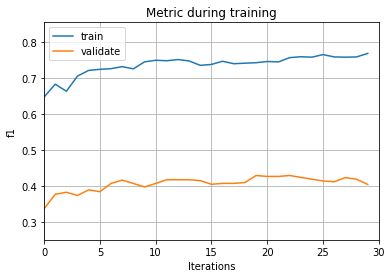

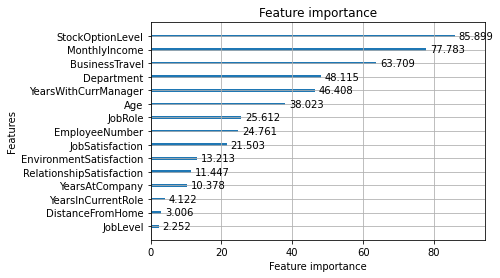

In [6]:
y_pred_train = gbm.predict(dftrain.drop('label',axis = 1), num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(dftest.drop('label',axis = 1), num_iteration=gbm.best_iteration)

print('train accuracy: {:.5} '.format(accuracy_score(dftrain['label'],y_pred_train>0.5)))
print('valid accuracy: {:.5} \n'.format(accuracy_score(dftest['label'],y_pred_test>0.5)))

lgb.plot_metric(results)
lgb.plot_importance(gbm,importance_type = "gain")

Confusion matrix, without normalization
[[165  81]
 [ 12  35]]


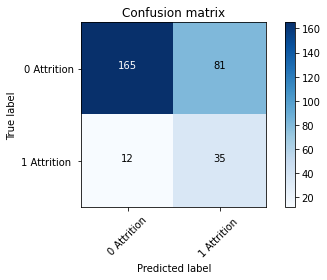

In [7]:
plot_confusion_matrix(confusion_matrix(dftest['label'],y_pred_test>0.5),target_names)

In [8]:
print(classification_report(dftest['label'],y_pred_test>0.5))

              precision    recall  f1-score   support

           0       0.93      0.67      0.78       246
           1       0.30      0.74      0.43        47

    accuracy                           0.68       293
   macro avg       0.62      0.71      0.60       293
weighted avg       0.83      0.68      0.72       293



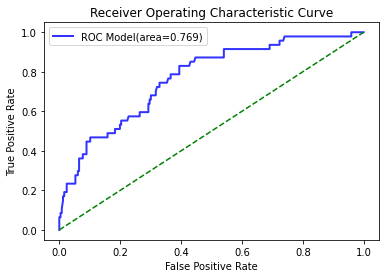

In [9]:
fper, tper, thresholds = roc_curve(dftest['label'], y_pred_test)
roc_auc=auc(fper,tper)
plot_roc_curve(fper, tper,roc_auc)

# Over

In [10]:
dftrain,dftest = df1,df2
y = dftrain['label']
X = dftrain.drop(['label'],axis = 1)
counter = Counter(y)
print(counter)
# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)

Counter({0: 987, 1: 190})
Counter({1: 987, 0: 987})


In [11]:
categorical_features = df_cat.columns[:-1].tolist()
lgb_train = lgb.Dataset(X,label=y,
                        categorical_feature = categorical_features)
lgb_valid = lgb.Dataset(dftest.drop(['label'],axis = 1),label=dftest['label'],
                                categorical_feature = categorical_features,
                                reference=lgb_train)
boost_round = 50                   
early_stop_rounds = 10
params = {  
    'boosting_type': 'gbdt',  
    'objective': 'binary',  
    'metric': ['f1'],  
    'tree_learner': 'data',
    'num_leaves': 64,  
    'max_depth': -1,  
    'min_data_in_leaf': 64,  
    'learning_rate': 0.09,  
    'feature_fraction': 0.9,  
    'bagging_fraction': 0.9,  
    'bagging_freq': 10,  
    'lambda_l1': 0,    
    'lambda_l2': 0,  # 越小l2正则程度越高  
    'min_gain_to_split': 0.1,  
    'verbose': 1,  
    'max_bin': 64,
#             'scale_pos_weight':5,
    'min_sum_hessian_in_leaf': 1,
    'task': 'train',

}  
params['is_unbalance']=False


def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True


results = {}
gbm = lgb.train(params,
                lgb_train,
                num_boost_round= boost_round,
                valid_sets=(lgb_valid, lgb_train),
                valid_names=('validate','train'),
                early_stopping_rounds = early_stop_rounds,
                evals_result= results,feval=lgb_f1_score)

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 987, number of negative: 987
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.705990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 420
[LightGBM] [Info] Number of data points in the train set: 1974, number of used features: 26


/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	train's f1: 0.770845	validate's f1: 0.322581
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	train's f1: 0.791267	validate's f1: 0.299065
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	train's f1: 0.813129	validate's f1: 0.3125
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	train's f1: 0.803392	validate's f1: 0.34
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	train's f1: 0.824524	validate's f1: 0.30303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	train's f1: 0.832985	validate's f1: 0.32
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	train's f1: 0.833245	validate's f1: 0.315789
[Li

train accuracy: 0.79439 
valid accuracy: 0.77474 



<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

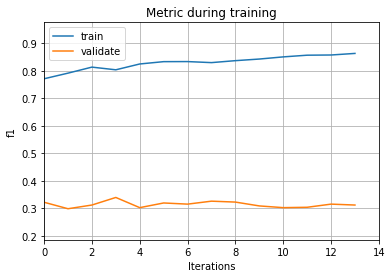

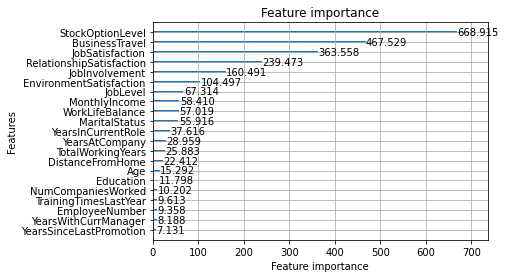

In [12]:
y_pred_train = gbm.predict(dftrain.drop('label',axis = 1), num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(dftest.drop('label',axis = 1), num_iteration=gbm.best_iteration)

print('train accuracy: {:.5} '.format(accuracy_score(dftrain['label'],y_pred_train>0.5)))
print('valid accuracy: {:.5} \n'.format(accuracy_score(dftest['label'],y_pred_test>0.5)))

lgb.plot_metric(results)
lgb.plot_importance(gbm,importance_type = "gain")

Confusion matrix, without normalization
[[210  36]
 [ 30  17]]


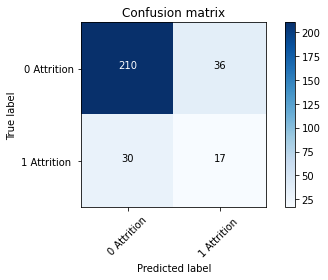

In [13]:
plot_confusion_matrix(confusion_matrix(dftest['label'],y_pred_test>0.5),target_names)

In [14]:
print(classification_report(dftest['label'],y_pred_test>0.5))

              precision    recall  f1-score   support

           0       0.88      0.85      0.86       246
           1       0.32      0.36      0.34        47

    accuracy                           0.77       293
   macro avg       0.60      0.61      0.60       293
weighted avg       0.79      0.77      0.78       293



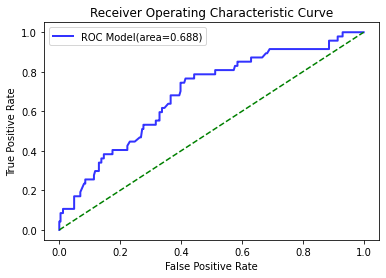

In [15]:
fper, tper, thresholds = roc_curve(dftest['label'], y_pred_test)
roc_auc=auc(fper,tper)
plot_roc_curve(fper, tper,roc_auc)